# Lightweight Fine-Tuning Project

Below I list the PEFT technique, the model, evaluation approach and fine-tunning dataset I'll be using to fine tune the LLM
* PEFT technique: LoRA
* Model: Llama 3.1 8B
* Evaluation approach: Hugging Face Trainer.evaluate
* Fine-tuning dataset: [AuthorMix](https://huggingface.co/datasets/hallisky/AuthorMix)

## Loading and Evaluating a Foundation Model

Loading Llama 3.1 8B model and evaluate its performance prior to fine-tuning. This includes loading an appropriate tokenizer and dataset.

## Load in IMDB Dataset

In [9]:
from datasets import load_dataset

# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42)

# Show the dataset
ds

{'train': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 14579
 }),
 'test': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 4747
 })}

### Dataset Exploration

In [10]:
import pandas as pd

train_df = pd.DataFrame(ds['train'])

print(train_df.head())

       style                                               text category
0  blog11518  "Jamaia....come and help me talk some sense in...     blog
1  blog25872  I decided I wasn't going to go to Boler today....     blog
2      obama  For over two decades, bin Laden has been al Qa...   speech
3  blog11518  motion with precise timing. Sucking the cigare...     blog
4  blog11518  "So what, we just stand here?" Alyx prompts, h...     blog


The dataset contains 14 unique authors

In [11]:
unique_styles = train_df['style'].unique()
print(unique_styles)

['blog11518' 'blog25872' 'obama' 'fitzgerald' 'hemingway' 'woolf' 'bush'
 'blog30102' 'blog5546' 'trump' 'blog30407' 'qq' 'pp' 'h']


In 4 number of formats/categories

In [12]:
unique_formats = train_df['category'].unique()
print(unique_formats)

['blog' 'speech' 'author' 'amt']


Dataset sample text length just skew towards 335 characters or less 

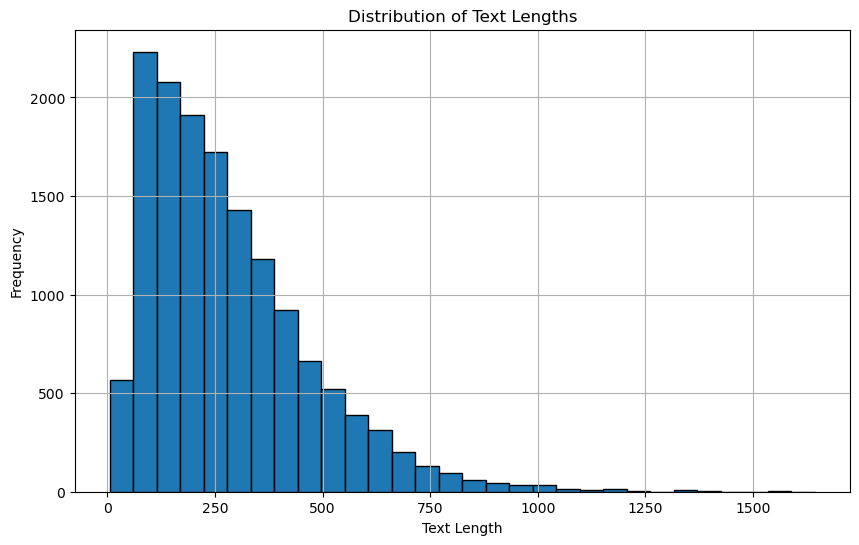

In [13]:
import matplotlib.pyplot as plt

train_df['text_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Intial Llama 3.1 8B evaluation on the dataset
Going to load in the Llama model through AutoModelForSequenceClassification and set the label ids

In [14]:
import torch
import os
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv("env.txt")
hf_token = os.getenv('HF_API_TOKEN')
login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/david/.cache/huggingface/token
Login successful


In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

num_labels = len(unique_styles)
id2label = {i: style for i, style in enumerate(unique_styles)}
label2id = {v: k for k, v in id2label.items()}
print(f"num_labels: {num_labels}")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

model_key = "openai-community/gpt2"
model = AutoModelForSequenceClassification.from_pretrained(
    model_key,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    use_auth_token=True,
)

/Users/david/Personal/Personal-Learning/foundational-modal-tuning/env/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


num_labels: 14
id2label: {0: 'blog11518', 1: 'blog25872', 2: 'obama', 3: 'fitzgerald', 4: 'hemingway', 5: 'woolf', 6: 'bush', 7: 'blog30102', 8: 'blog5546', 9: 'trump', 10: 'blog30407', 11: 'qq', 12: 'pp', 13: 'h'}
label2id: {'blog11518': 0, 'blog25872': 1, 'obama': 2, 'fitzgerald': 3, 'hemingway': 4, 'woolf': 5, 'bush': 6, 'blog30102': 7, 'blog5546': 8, 'trump': 9, 'blog30407': 10, 'qq': 11, 'pp': 12, 'h': 13}


### Preprocess dataset

In [27]:
from datasets import DatasetDict

# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained(model_key, use_auth_token=True)
tokenizer.pad_token = tokenizer.eos_token

# Preprocessing function
def preprocess_function(examples):
    tokens = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)
    tokens['label'] = [label2id[style] for style in examples['style']]
    return tokens
    
# Tokenize the dataset
tokenized_ds = DatasetDict()
for split in splits:
    tokenized_ds[split] = ds[split].map(preprocess_function, batched=True)

model.resize_token_embeddings(len(tokenizer))

# Ensure the tokenized dataset is converted to PyTorch tensors
tokenized_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Directly access the batched inputs from the dataset
inputs = {
    'input_ids': tokenized_ds['test']['input_ids'],
    'attention_mask': tokenized_ds['test']['attention_mask'],
    'labels': tokenized_ds['test']['label']
}


Map:   0%|          | 0/14579 [00:00<?, ? examples/s]

Map:   0%|          | 0/4747 [00:00<?, ? examples/s]

In [28]:
# Move inputs to device (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=14, bias=False)
)

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(**inputs)